In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import plotly.express as px
import plotly.graph_objects as go


In [3]:
# Load the datasets
users_df = pd.read_csv('users_data.csv')
cards_df = pd.read_csv('cards_data.csv')
transactions_df = pd.read_csv('transactions_data.csv')

with open('train_fraud_labels.json', 'r') as f:
    fraud_labels = json.load(f)

with open('mcc_codes.json', 'r') as f:
    mcc_codes = json.load(f)

# Convert fraud labels to DataFrame
fraud_df = pd.DataFrame(list(fraud_labels['target'].items()), columns=['id', 'is_fraud'])
fraud_df['is_fraud'] = fraud_df['is_fraud'].map({'Yes': 1, 'No': 0})

# Convert id columns to the same type before merging
fraud_df['id'] = fraud_df['id'].astype(str)
transactions_df['id'] = transactions_df['id'].astype(str)
users_df['id'] = users_df['id'].astype(str)
cards_df['client_id'] = cards_df['client_id'].astype(str)
transactions_df['client_id'] = transactions_df['client_id'].astype(str)

# Merge transactions with fraud labels
merged_df = transactions_df.merge(fraud_df, on='id', how='left')

# Convert date column to datetime
merged_df['date'] = pd.to_datetime(merged_df['date'],  format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Handle any parsing errors in the date column
merged_df = merged_df.dropna(subset=['date'])

# Extract hour from datetime for hourly fraud analysis
merged_df['hour'] = merged_df['date'].dt.hour

# Merge with users data to get credit scores
merged_df = merged_df.merge(users_df[['id', 'credit_score']], left_on='client_id', right_on='id', how='left', suffixes=('', '_user'))

# Merge with cards data to get credit limits
merged_df = merged_df.merge(cards_df[['client_id', 'credit_limit']], on='client_id', how='left')

# Clean up credit_limit column (remove $ and convert to numeric)
merged_df['credit_limit'] = merged_df['credit_limit'].str.replace('$', '', regex=False).astype(float)

# Clean up amount column if it has $ format
if isinstance(merged_df['amount'].iloc[0], str):
    merged_df['amount'] = merged_df['amount'].str.replace('$', '', regex=False).astype(float)

# Add MCC descriptions 
# Convert mcc to string to ensure proper mapping
merged_df['mcc'] = merged_df['mcc'].astype(str)
mcc_map = {str(k): v for k, v in mcc_codes.items()}
merged_df['mcc_description'] = merged_df['mcc'].map(mcc_map)

# Fill missing MCC descriptions
merged_df['mcc_description'] = merged_df['mcc_description'].fillna('Unknown')

FileNotFoundError: [Errno 2] No such file or directory: 'users_data.csv'

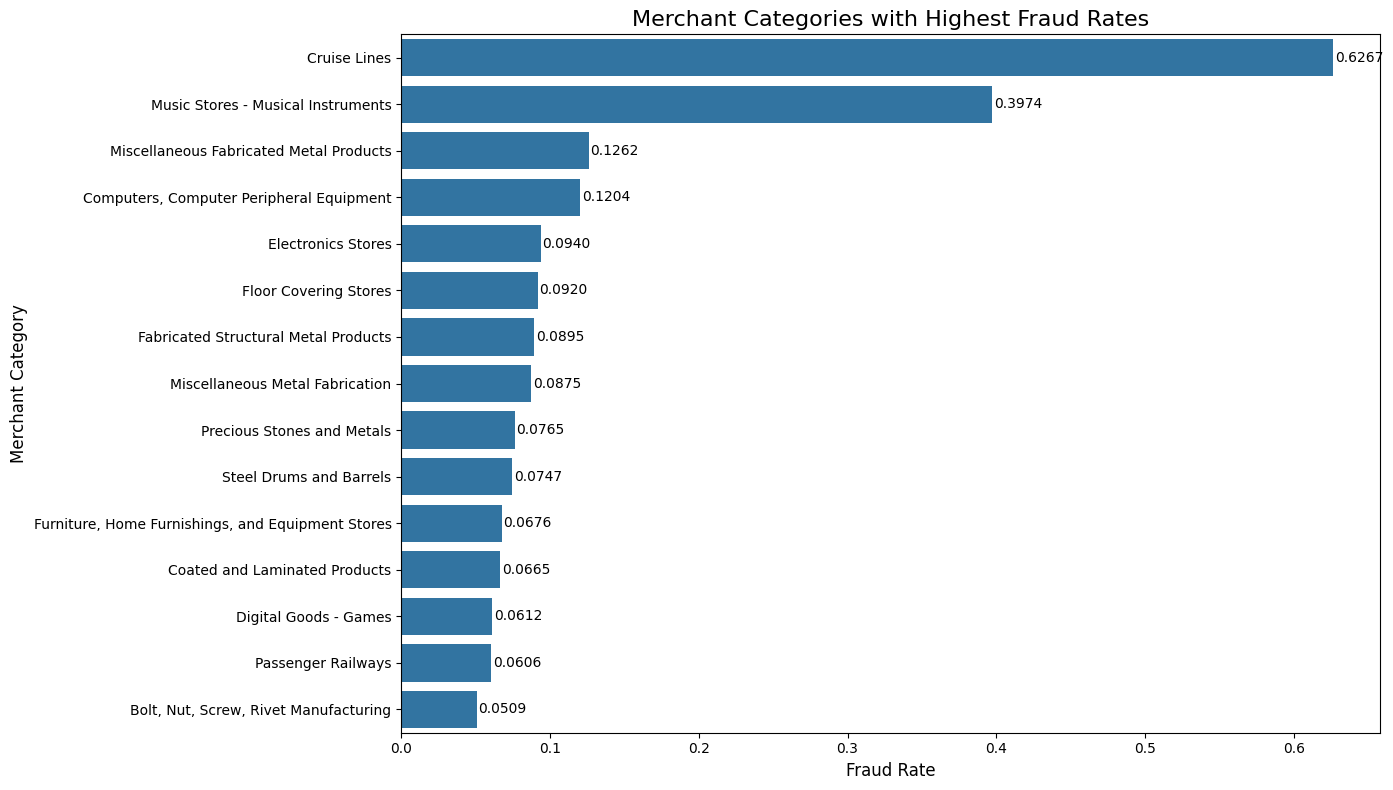

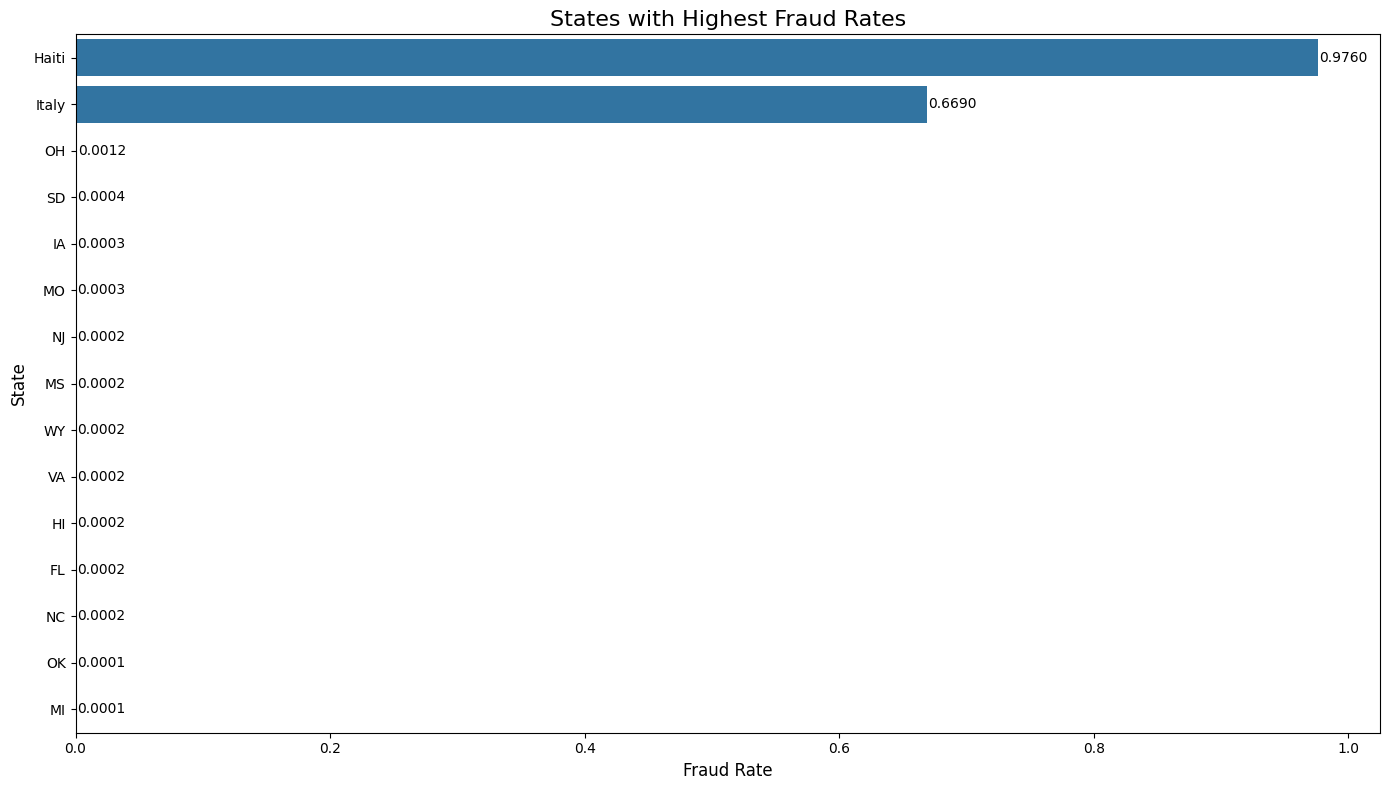

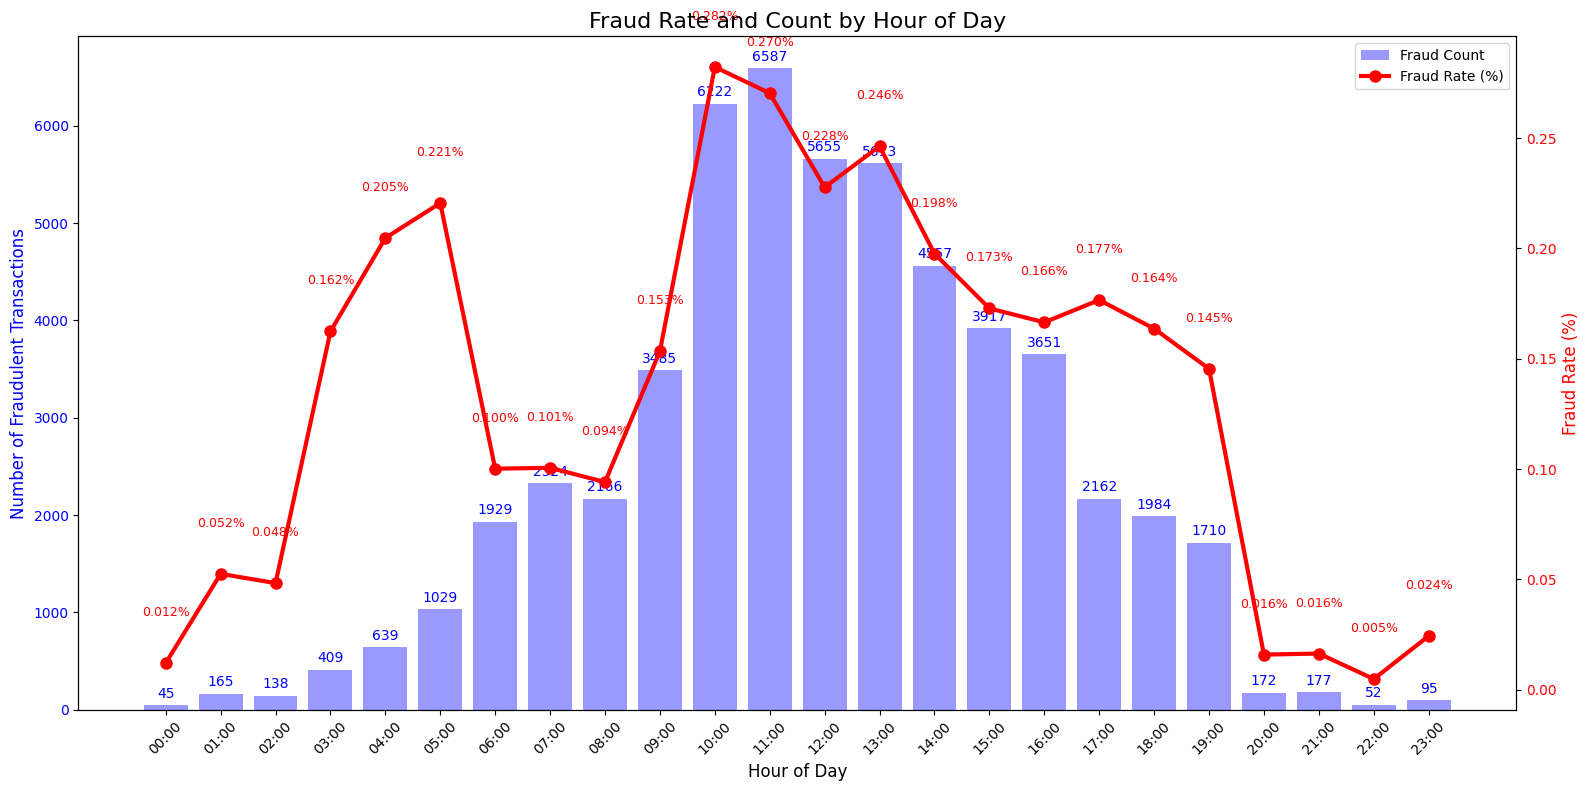

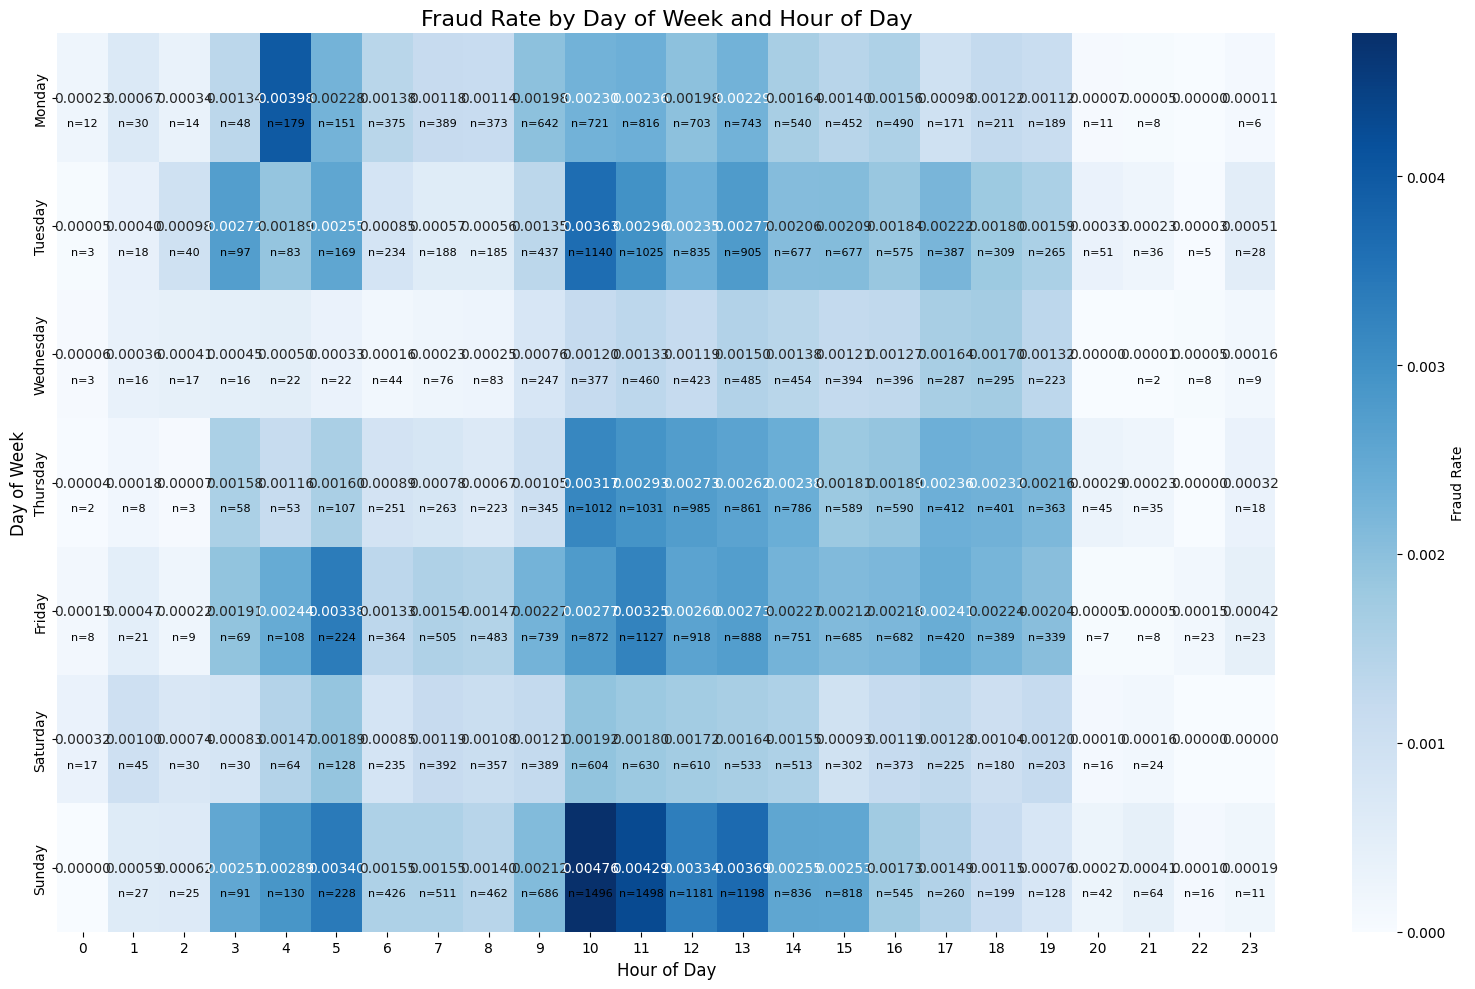

Fraudulent Transactions by Hour of Day:


,Hour,Fraud_Count,Fraud_Rate
0,0,45.0,0.0120%
1,1,165.0,0.0525%
2,2,138.0,0.0483%
3,3,409.0,0.1624%
4,4,639.0,0.2047%
5,5,1029.0,0.2205%
6,6,1929.0,0.1001%
7,7,2324.0,0.1005%
8,8,2166.0,0.0941%
9,9,3485.0,0.1534%


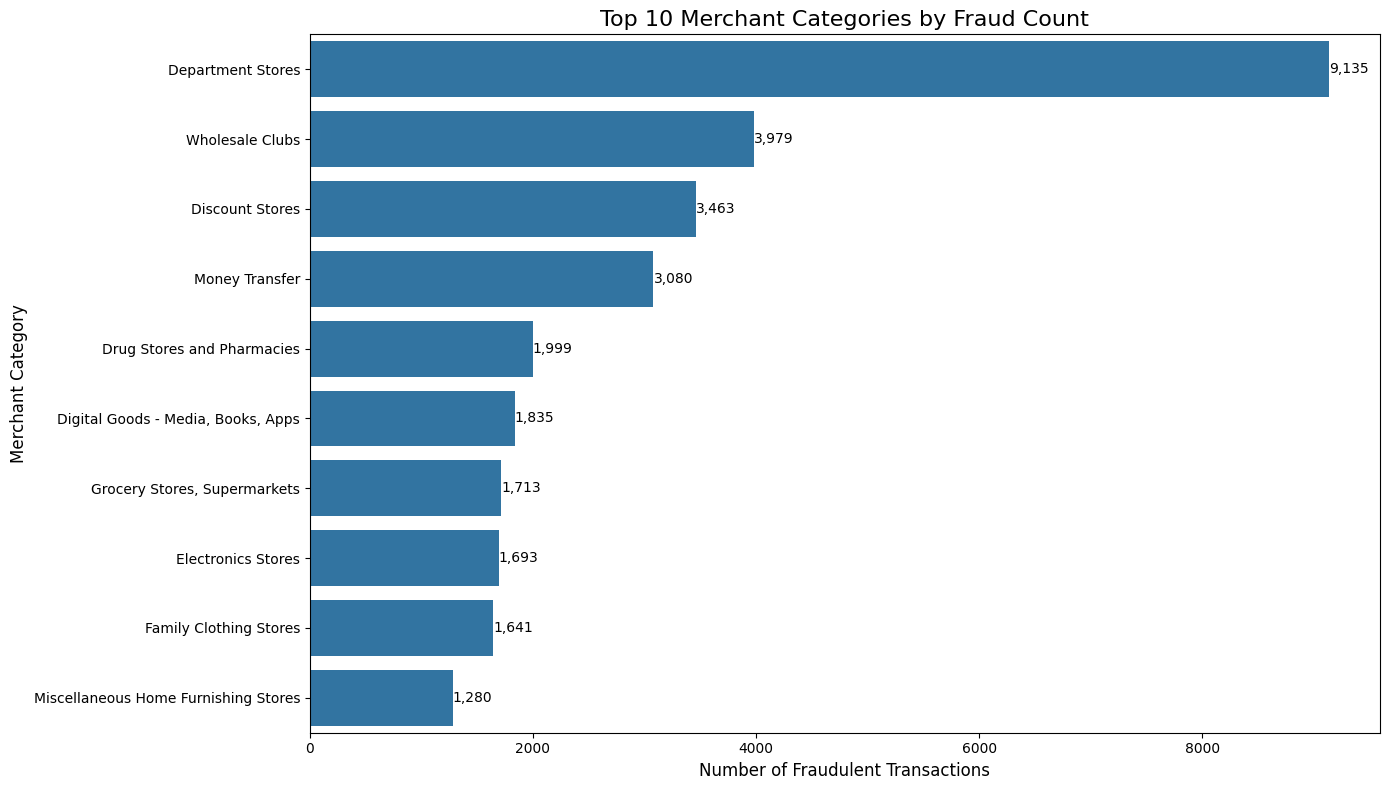

In [5]:
# 1. Visualize fraud by MCC code - DISPLAYED IN NOTEBOOK
plt.figure(figsize=(14, 8))
mcc_fraud = merged_df.groupby(['mcc', 'mcc_description'])['is_fraud'].mean().reset_index()
mcc_fraud = mcc_fraud.sort_values('is_fraud', ascending=False).head(15)

ax = sns.barplot(x='is_fraud', y='mcc_description', data=mcc_fraud)
plt.title('Merchant Categories with Highest Fraud Rates', fontsize=16)
plt.xlabel('Fraud Rate', fontsize=12)
plt.ylabel('Merchant Category', fontsize=12)
plt.tight_layout()

# Add percentage labels to bars
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.001, p.get_y() + p.get_height()/2, f'{width:.4f}', 
             ha='left', va='center')

plt.show()  # Explicitly show the plot in the notebook

# 2. Visualize fraud by state - DISPLAYED IN NOTEBOOK
plt.figure(figsize=(14, 8))
state_fraud = merged_df.groupby('merchant_state')['is_fraud'].agg(['mean', 'count']).reset_index()
state_fraud = state_fraud[state_fraud['count'] > 100]  # Filter out states with too few transactions
state_fraud = state_fraud.sort_values('mean', ascending=False).head(15)

ax = sns.barplot(x='mean', y='merchant_state', data=state_fraud)
plt.title('States with Highest Fraud Rates', fontsize=16)
plt.xlabel('Fraud Rate', fontsize=12)
plt.ylabel('State', fontsize=12)

# Add percentage labels to bars
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.001, p.get_y() + p.get_height()/2, f'{width:.4f}', 
             ha='left', va='center')

plt.tight_layout()
plt.show()  # Explicitly show the plot in the notebook


# 6. Visualize fraud by hour of day - DISPLAYED IN NOTEBOOK
hourly_fraud = merged_df.groupby('hour')['is_fraud'].agg(['mean', 'count', 'sum']).reset_index()
hourly_fraud = hourly_fraud.fillna(0)  # Handle any NaN values

fig, ax1 = plt.subplots(figsize=(16, 8))
ax2 = ax1.twinx()

# Bar chart for fraud count
bars = ax1.bar(hourly_fraud['hour'], hourly_fraud['sum'], alpha=0.4, color='blue', label='Fraud Count')
ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.set_ylabel('Number of Fraudulent Transactions', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

# Add count labels to bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:  # Only show labels for bars with data
        ax1.text(bar.get_x() + bar.get_width()/2, height + 50, 
                 f'{int(height)}', ha='center', va='bottom', color='blue')

# Line chart for fraud rate
line = ax2.plot(hourly_fraud['hour'], hourly_fraud['mean'] * 100, 'r-o', linewidth=3, 
                markersize=8, label='Fraud Rate (%)')
ax2.set_ylabel('Fraud Rate (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Add percentage labels to line points
for i, rate in enumerate(hourly_fraud['mean'] * 100):
    ax2.text(i, rate + 0.02, f'{rate:.3f}%', ha='center', va='bottom', 
             color='red', fontsize=9)

ax1.set_xticks(range(0, 24))
ax1.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45)
ax1.grid(False)
ax2.grid(False)

plt.title('Fraud Rate and Count by Hour of Day', fontsize=16)

# Create custom legend with items from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.tight_layout()
plt.show()  # Explicitly show the plot in the notebook

# 7. Create a heatmap of fraud by day of week and hour of day - DISPLAYED IN NOTEBOOK
merged_df['day_of_week'] = merged_df['date'].dt.day_name()
merged_df['hour'] = merged_df['date'].dt.hour

# Order days of week correctly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
merged_df['day_of_week'] = pd.Categorical(merged_df['day_of_week'], categories=day_order, ordered=True)

# Group by day and hour with observed=True to avoid the warning
day_hour_fraud = merged_df.groupby(['day_of_week', 'hour'], observed=True)['is_fraud'].mean().unstack().fillna(0)

plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(day_hour_fraud, cmap='Blues', annot=True, fmt='.5f', 
                     cbar_kws={'label': 'Fraud Rate'})
plt.title('Fraud Rate by Day of Week and Hour of Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)

# Add count annotations to cells
day_hour_count = merged_df.groupby(['day_of_week', 'hour'], observed=True)['is_fraud'].sum().unstack().fillna(0)
for i in range(len(day_hour_fraud.index)):
    for j in range(len(day_hour_fraud.columns)):
        count = int(day_hour_count.iloc[i, j])
        if count > 0:
            text = plt.text(j + 0.5, i + 0.7, f'n={count}', 
                           ha='center', va='center', color='black', fontsize=8)

plt.tight_layout()
plt.show()  # Explicitly show the plot in the notebook

# Show the detailed hourly fraud table
hourly_fraud_table = hourly_fraud[['hour', 'sum', 'mean']].rename(
    columns={'hour': 'Hour', 'sum': 'Fraud_Count', 'mean': 'Fraud_Rate'})
hourly_fraud_table['Fraud_Rate'] = hourly_fraud_table['Fraud_Rate'] * 100
hourly_fraud_table['Fraud_Rate'] = hourly_fraud_table['Fraud_Rate'].map('{:.4f}%'.format)
hourly_fraud_table = hourly_fraud_table.sort_values('Hour')

print("Fraudulent Transactions by Hour of Day:")
display(hourly_fraud_table)

# 8. Visualize MCC distribution of fraudulent transactions - DISPLAYED IN NOTEBOOK
# Get top 10 MCCs with highest fraud counts
fraud_mcc_counts = merged_df[merged_df['is_fraud'] == 1].groupby(['mcc_description'])['id'].count().reset_index()
fraud_mcc_counts.columns = ['MCC Description', 'Fraud Count']
fraud_mcc_counts = fraud_mcc_counts.sort_values('Fraud Count', ascending=False).head(10)

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Fraud Count', y='MCC Description', data=fraud_mcc_counts)
plt.title('Top 10 Merchant Categories by Fraud Count', fontsize=16)
plt.xlabel('Number of Fraudulent Transactions', fontsize=12)
plt.ylabel('Merchant Category', fontsize=12)

# Add count labels
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 1, p.get_y() + p.get_height()/2, f'{int(width):,}', 
             ha='left', va='center')

plt.tight_layout()
plt.show()  # Explicitly show the plot in the notebook